In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from ToyTrajectoryNet.utils import generate_steps, set_seeds, config_criterion
from ToyTrajectoryNet.models import make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train, train_ae
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.geo import setup_distance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time, pickle, scprep

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [2]:
data_dir = os.path.join(DATA_DIR, '../../', 'mau-at2/data')

In [3]:
FILE_MAGIC = os.path.join(data_dir, f'noble_magic.pickle')
FILE_MAGIC_OP = os.path.join(data_dir, f'noble_magic_op.pickle')
FILE_DF_AT = os.path.join(data_dir, f'noble_df.pickle')
FILE_DF_PHATE = os.path.join(data_dir, f'noble_df_phate.pickle')

FILE_PSEUDOTIME = os.path.join(data_dir, f'noble-pseudotime-1.npy')

with open(FILE_MAGIC, 'rb') as f:
    # DataFrame of cells x genes after MAGIC
    df_m = pickle.load(f)
with open(FILE_MAGIC_OP, 'rb') as f:
    # Magic Operator used to create df_m
    magic_op = pickle.load(f)    
with open(FILE_DF_AT, 'rb') as f:
    # DataFrame of cells x genes before MAGIC
    df_at = pickle.load(f)
with open(FILE_DF_PHATE, 'rb') as f:
    # DataFrame of cells x phate with time samples
    df_p = pickle.load(f)    
ptime = np.load(FILE_PSEUDOTIME)

In [4]:
ptime_int = np.round(ptime / np.max(ptime) * 10, 10).astype(int)
ptime_int[ptime_int == 5] = 4

ptime_int[ptime_int == 6] = 5
ptime_int[ptime_int == 7] = 5

ptime_int[ptime_int == 8] = 6
ptime_int[ptime_int == 9] = 6
ptime_int[ptime_int == 10] = 6

In [5]:
# DataFrame with phate but pseudotime
df_pp = (df_p.drop(columns='samples') * 100).join(pd.DataFrame(ptime_int, columns=['samples']))

In [6]:
np.round(ptime / 1000)

array([ 26.,  33.,   6., ..., 102., 159.,  31.])

In [7]:
np.unique(ptime_int, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([2453, 2164, 1361,  950,  842,  502,  614]))

/home/solstice/anaconda3/envs/ml/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes3DSubplot:xlabel='d1', ylabel='d2'>

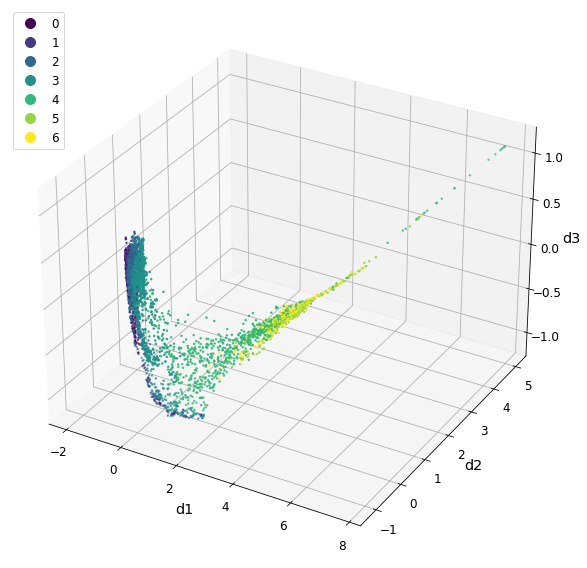

In [8]:
scprep.plot.scatter3d(
    df_pp.drop(columns='samples'), 
    c=ptime_int, 
#     c=df_p.samples, 
    figsize=(12, 8), cmap='viridis'
)

In [9]:
import scanpy as sc, phate, scprep
run = False
if run:
    phate_operator = phate.PHATE(n_components=10, n_jobs=-1)
    Y_phate = phate_operator.fit_transform(df_m)

    pca_loadings = phate_operator.graph.data_nu
    pca_components = phate_operator.graph.data_pca.components_

In [10]:
# NOTE: the _m suffix is because we run phate here on the df_m (magic data)
# versus the df_at which is data premagic (no _m suffix)
save = False
if save:
    with open(os.path.join(data_dir, f'noble_y_phate_m.pickle'), 'wb') as f:
        pickle.dump(Y_phate, f)

    with open(os.path.join(data_dir, f'noble_pca_loadings_m.pickle'), 'wb') as f:
        pickle.dump(pca_loadings, f)

    with open(os.path.join(data_dir, f'noble_pca_components_m.pickle'), 'wb') as f:
        pickle.dump(pca_components, f)

In [11]:
load = True
if load:
    with open(os.path.join(data_dir, f'noble_y_phate.pickle'), 'rb') as f:
        Y_phate = pickle.load(f)

    with open(os.path.join(data_dir, f'noble_pca_loadings.pickle'), 'rb') as f:
        pca_loadings = pickle.load(f)

    with open(os.path.join(data_dir, f'noble_pca_components.pickle'), 'rb') as f:
        pca_components = pickle.load(f)
        
        
    with open(os.path.join(data_dir, f'noble_y_phate_m.pickle'), 'rb') as f:
        Y_phate = pickle.load(f)

    with open(os.path.join(data_dir, f'noble_pca_loadings_m.pickle'), 'rb') as f:
        pca_loadings = pickle.load(f)

    with open(os.path.join(data_dir, f'noble_pca_components_m.pickle'), 'rb') as f:
        pca_components = pickle.load(f)

/home/solstice/anaconda3/envs/ml/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:>

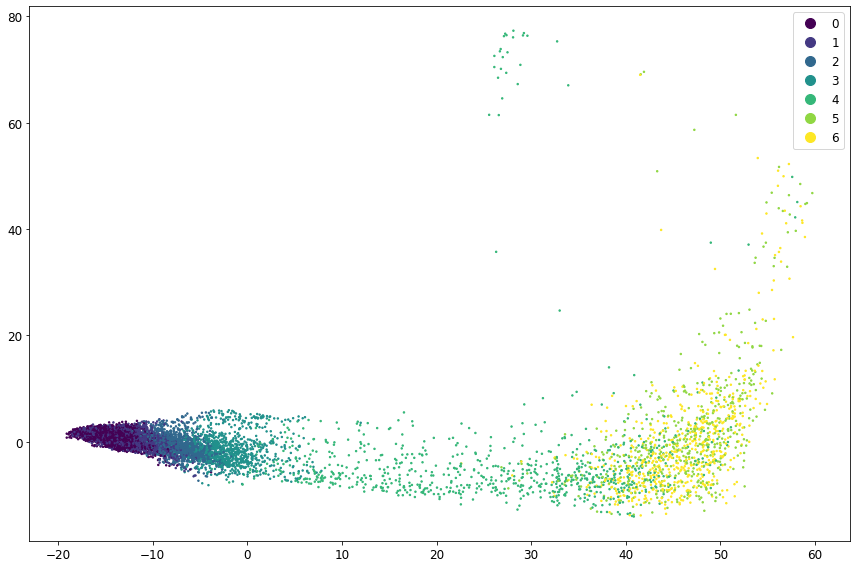

In [12]:
scprep.plot.scatter2d(
    pca_loadings, 
    c=ptime_int, 
#     c=df_p.samples, 
    figsize=(12,8), cmap="viridis",
#     azim=145, elev=45
)

In [13]:
df_pca = pd.DataFrame(pca_loadings, columns=[f'd{i}' for i in range(1, 101)]).join(
    pd.DataFrame(ptime_int, columns=['samples'])
)

In [14]:
df = df_pca

# Load Genes

In [15]:
data_dir = os.path.join(DATA_DIR, '../../', 'mau-at2/data')

In [16]:
# Load raw file
df_genes = pd.read_csv(os.path.join(data_dir, 'Migration genes.csv'))

# Filter our missing
for key in np.unique(df_genes.values.flatten().astype(str)):
    if key not in df_at.columns:
        df_genes.replace(key, None, inplace=True)
        
# Drop NAs independently        
gene_lists = {}
max_length = 0
for _type in df_genes.columns:
    genes = df_genes[_type].dropna().values
    if len(genes) > max_length:
        max_length = len(genes)
    gene_lists[_type] = genes

# Fix mismatch lengths
for key, val in gene_lists.items():
    if len(val) < max_length:
        gene_lists[key] = np.pad(val, (0, max_length - len(val)))

# Restore corrected
df_genes = pd.DataFrame(gene_lists)  
df_genes

Adhesion Volume     Shape Migration
0       Actb    Ahr     Aldoa     Abhd2
1      Actg1  Anxa7     Anxa1     Actg1
2      Actn1   Apoe     Anxa7    Acvr1c
3        Ada   Aqp1  Arhgap15       Ada
4      Adam8   Aqp2    Baiap2     Adam8
..       ...    ...       ...       ...
328     Wnt4      0         0         0
329    Wnt7b      0         0         0
330   Ythdf2      0         0         0
331  Zfp36l1      0         0         0
332      Zyx      0         0         0

[333 rows x 4 columns]

## Genes from Strunz et al

In [17]:
page_4 = '''
Acoxl Fabp1 Lgi3 Slc34a2 Gzma Arhgef38 Aox3 Lamp3 Ppp1r14c Lyz1 Chi3l1 Itih4 Cxcl15 Acot1 Enpep Sftpa1 Atp6v1c2 
Slc4a5 Ank3 Tinag Pgam1 Lox Ecm1 Tpm2 Cxcl14 C1qc Thbs1 C1qa C1qb Mmp19 mmp12 Emilin2 S100a4 Serpina3n Gpnmb Fn1 
Msr1 Tnc Spp1 Arg1
'''.split()
page_5 = '''
Sftpc Sbr2 Sftpa1 Cxcl15 Lgi3 Fabp5 
Lcn2 Il33 Ifi27l2a Retnla 
Rtkn2 Hopx Pdpn Ager Vegfa Clic5 Igfbp2 Spock2
'''.split()

page_8 = '''
Cyp2f2 Scgb1a1 Hp Cbr2 Scgb3a2 Mgst1 Selenbp1 Fmo2 Retnla Alas1 Pigr mt-Co1 Prdx6 
Cp mt-Cytb Aldh1a1 Ppap2b Por Gsta3 Mettl7a1 Cldn10 Aldh1a7 Ldhb Gsta4 Pon1 Cst3 
H2-Ab1 Cd74 H2-Eb1 Psap Ctss Vim H2-Aa Laptm5 Actb Alox5ap Srgn Ccl17 Lsp1 Scgb3a1 S100a4
'''.split()

page_4 = [g for g in page_4 if g in df_at.columns]
page_5 = [g for g in page_5 if g in df_at.columns]
page_8 = [g for g in page_8 if g in df_at.columns]

In [18]:
# from http://geneontology.org/
motility_genes = '''
Cd9 Hyal2 Gadd45a Tgfb1 Bag4 Prkca Mmp14 Syne2 Igf1r Sema3c Tgfb2 Mylk Kitl Glul Csf1r Lcn2 Epcam Ldlrad4 Ttf1 Reck F2rl1 
Irs2 Fgf1 Plk2 Wnt4 Notch1 Bmpr2 Rap2b Dicer1 Plxna1 Cnn2 Itga3 Il1b Gnai2 Arhgdib Ccar1 Osgin1 Ctsh Thbs1 Tgfb1 Dusp3 
Icam1 Mysm1 Fermt2 Glipr2 Serpine1 Anxa5 Thy1 Cldn3 Lama5 Ptgs2 Ptn Lamc2 Clic4 Dusp1 Anxa3 Gpsm3 Dnaja4 Rhob Mapk8 Foxo4 
Nbl1 Ccr7 Tmsb4x Rras Adamts1 Fam49b Plxna2 Rarres2 Cd81 Smpd3 Cd200 Fermt1 Hmox1 Bcr Bmp2 Pdgfa Appl2 Epha2 Arid2 Ptprm 
Itgav Tnn Rcc2 Vim Ppp3ca Tgfbr1 Mpp1 Ttll6 Cxcl17 Cxcl16 Prcp Vcl Hc Sp1 Trib1 Ing2 Bex4 F2r Dusp10 Tgfbr3 Adora2b Mbd1 
Pycard Sema6a Lamb1 Prkce Zc3h12a Sema4b Gas6 Coro1c Lgmn Msn S100a11 Igfbp5 Sash1 Pik3c2a Bst2 Sema5a Cited2 Inpp5f 
Wdpcp Jag1 Cxcr4 Pdgfb Calr Gstp2 Amotl2 Rras2 Sdc4 Arhgap5 Ulk4 Srf Lama4 Plxna4 Nrp1 Sp100 Itgb3 Itgb1 Ninj1 Klf4 
Arid4a Grn Rlf Amotl1 Jun Cygb Tacstd2 Hspb1 Iqgap1 Sema3f Apoe Swap70 Emp2 Lrig2 Ddx58 Efcab1 Actg1 Apc Sema3e Ptprz1 
Arhgap18 Rgcc Ifitm3 Rac2 Egr1 Spry2 Nexn Hbegf Gstp1 Dapk2 Rock2 F3 Anxa1 Kank1 Coro1a Edn1 Ccl5 St3gal4 Rock1 Ctnna1 
Abhd2 Map3k3 Bmp4 Ptprg
'''.split()

cytoskeleton_genes = [
    'Ezr', 'Marcks', 'Casp4', 'Fam171a1', 'Cnn3', 'Foxj1', 'Csrp2', 'Nebl', 'Hcls1', 'Krt19', 'Hsp90b1', 'Fhod1', 
    'Arpc5l', 'Rnd3', 'F11r', 'Cnn2', 'Tyrobp', 'Myh9', 'Tmod1', 'Csrp1', 'Cdc42bpg', 'Dstn', 'Cldn3', 'Cckar', 'Rhob', 
    'Ccr7', 'Tmsb4x', 'Fan1', 'Bcr', 'Cald1', 'Bag4', 'Gba2', 'Tgfb2', 'Csf1r', 'F2rl1', 'S100a10', 'Hcls1', 'Wnt4', 
    'Kank3', 'Stmn1', 'Fhod1', 'Kank2', 'Arpc5l', 'Rnd3', 'F11r', 'Arhgdib', 'Tgfb1', 'Tmod1', 'Icam1', 'Fermt2', 
    'Dstn', 'Ctgf', 'Rhob', 'Tmsb4x', 'Fam49b', 'Cotl1', 'Fan1', 'Prkcd', 'Ccdc88a', 'Cd2ap'
]

cell_motility_genes = [
    'Cd9', 'Hyal2', 'Gadd45a', 'Tgfb1', 'Bag4', 'Prkca', 'Mmp14', 'Syne2', 'Igf1r', 'Sema3c', 'Tgfb2', 'Mylk', 
    'Kitl', 'Glul', 'Csf1r', 'Lcn2', 'Epcam', 'Ldlrad4', 'Ttf1', 'Reck', 'F2rl1', 'Irs2', 'Fgf1', 'Plk2', 'Wnt4', 
    'Notch1', 'Bmpr2', 'Rap2b', 'Dicer1', 'Plxna1'
]

cell_motility_genes_pos_reg = [
    'Tgfb1', 'Bag4', 'Prkca', 'Mmp14', 'Syne2', 'Igf1r', 'Sema3c', 'Tgfb2', 'Mylk', 'Kitl', 'Csf1r', 
    'Lcn2', 'Epcam', 'F2rl1', 'Irs2', 'Fgf1', 'Plk2', 'Notch1', 'Bmpr2', 'Dicer1', 'Itga3', 'Il1b', 
    'Gnai2', 'Ccar1', 'Ctsh', 'Thbs1', 'Tgfb1', 'Icam1', 'Fermt2', 'Glipr2'
]


cell_motility_genes_neg_reg = [
    'Hyal2', 'Gadd45a', 'Ldlrad4', 'Ttf1', 'Reck', 'Wnt4', 'Notch1', 'Rap2b', 'Cnn2', 'Arhgdib', 'Thbs1', 
    'Tgfb1', 'Dusp3', 'Serpine1', 'Thy1', 'Cldn3', 'Ptn', 'Clic4', 'Dusp1', 'Dnaja4', 'Rhob', 'Nbl1', 'Rras', 
    'Cd200', 'Bcr', 'Arid2', 'Ptprm', 'Tnn', 'Hc', 'Trib1'
]

adhesion_genes = [
    'Aggf1', 'Cdhr3', 'Marcks', 'Cd9', 'Tgfb1', 'Prkca', 'Tgfb2', 'Vmp1', 'Kitl', 'Epcam', 'Tgfbi', 
    'Pcdh1', 'Rap2b', 'Megf9', 'F11r', 'Itga3', 'Il1b', 'Efnb2', 'Fndc3b', 'Myh9', 'Thbs1', 'Atp1b1', 'Icam1', 
    'Aqp4', 'Fermt2', 'Alcam', 'Egfl6', 'Thy1', 'Cldn3', 'Col6a1'
]

adhesion_genes_pos_reg = [
    'S100a10', 'Wnt4', 'Plekha2', 'Dicer1', 'Fermt2', 'Thy1', 'Rras', 'Fermt1', 'Sdc4', 'Nrp1', 'Itgb3', 
    'Ninj1', 'Iqgap1', 'Emp2', 'Rock1', 'Utrn'
]

adhesion_genes_neg_reg = [
    'Adrb2', 'Cd9', 'Malt1', 'Prkca', 'Foxj1', 'B2m', 'Peli1', 'Epcam', 'Arg2', 'H2-DMb1', 'Wnt4', 
    'Notch1', 'Tfrc', 'Bap1', 'Fstl3', 'F11r', 'Il1b', 'Efnb2', 'Tgfb1', 'Dusp3', 'Icam1', 'Cd55', 
    'Igfbp2', 'Thy1', 'Zc3h8', 'Hsp90aa1', 'Nfkbid', 'Il4ra', 'Plaur', 'Il7r'
]


adhesion_cellular_matrix = [
    'S100a10', 'Wnt4', 'Plekha2', 'Dicer1', 'Fermt2', 'Thy1', 'Rras', 'Fermt1', 'Sdc4', 'Nrp1', 
    'Itgb3', 'Ninj1', 'Iqgap1', 'Emp2', 'Rock1', 'Utrn'
]

differentiation_genes_pos_reg = [
    'S100a10', 'Wnt4', 'Plekha2', 'Dicer1', 'Fermt2', 'Thy1', 'Rras', 'Fermt1', 'Sdc4', 'Nrp1', 
    'Itgb3', 'Ninj1', 'Iqgap1', 'Emp2', 'Rock1', 'Utrn'
]

stem_cell_genes = [
    'Kitl', 'Epcam', 'Fermt2', 'Cxcl1', 'Ncoa3', 'Pim1', 'Fermt1', 'Zfp36l1', 'Hmgb2', 
    'Taf4b', 'Ltbp3', 'Bmp4', 'N4bp2l2'
]

top_maor_genes = 'Aatf Ahr Anxa1 Abhd2 Actb Apoe Arhgap18 Actg1 Bambi Coro1a Wnt4'.split()

In [19]:
motility_genes = [g for g in motility_genes if g in df_at.columns]
cytoskeleton_genes = [g for g in cytoskeleton_genes if g in df_at.columns]
cell_motility_genes = [g for g in cell_motility_genes if g in df_at.columns]
cell_motility_genes_pos_reg = [g for g in cell_motility_genes_pos_reg if g in df_at.columns]
cell_motility_genes_neg_reg = [g for g in cell_motility_genes_neg_reg if g in df_at.columns]
adhesion_genes = [g for g in adhesion_genes if g in df_at.columns]
adhesion_genes_pos_reg = [g for g in adhesion_genes_pos_reg if g in df_at.columns]
adhesion_genes_neg_reg = [g for g in adhesion_genes_neg_reg if g in df_at.columns]
adhesion_cellular_matrix = [g for g in adhesion_cellular_matrix if g in df_at.columns]
differentiation_genes_pos_reg = [g for g in differentiation_genes_pos_reg if g in df_at.columns]
stem_cell_genes = [g for g in stem_cell_genes if g in df_at.columns]

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [20]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [21]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 'random'

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [52]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 32
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the thing

In [23]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 11.26433
Train loss dist: 1799.55713
Train loss recon: 10.16165
Train loss dist: 45.36979
Train loss recon: 9.57176
Train loss dist: 13.01665
Train loss recon: 9.01008
Train loss dist: 8.00606
Train loss recon: 8.20377
Train loss dist: 5.68877
Train loss recon: 8.17031
Train loss dist: 5.07248
Train loss recon: 7.96014
Train loss dist: 4.36242
Train loss recon: 6.94497
Train loss dist: 3.83437
Train loss recon: 6.82178
Train loss dist: 3.5911
Train loss recon: 6.40663
Train loss dist: 3.63562
Train loss recon: 5.92858
Train loss dist: 3.55514
Train loss recon: 4.78726
Train loss dist: 3.27975
Train loss recon: 4.23319
Train loss dist: 3.41282
Train loss recon: 3.97078
Train loss dist: 3.32527
Train loss recon: 3.89854
Train loss dist: 3.32364
Train loss recon: 3.7409
Train loss dist: 3.10948
Train loss recon: 3.58682
Train loss dist: 3.06827
Train loss recon: 3.63497
Train loss dist: 2.99159
Train loss recon: 3.4096
Train loss dist: 3.00044
Train loss recon: 3.48752
T

# Specify parameters

In [53]:
set_seeds(10)

#Directory where results are saved
exp_name = 'noble-7-5-2022'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 15

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda,
#     which='sde', method='euler'
)

In [54]:
# Basically "batch size"
sample_size=(30, )

# Training specification
n_local_epochs = 20
n_epochs = 20
n_post_local_epochs = 0

criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 20
n_trajectories = 100
n_bins = 100

reverse=True

In [55]:
opts = {
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse': reverse
}

In [56]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [57]:
from ToyTrajectoryNet.train import training_regimen

In [58]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    # END: train params

    plot_every=1,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
#     local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses,
    reverse_schema=reverse, reverse_n=2
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x103 and 35x16)

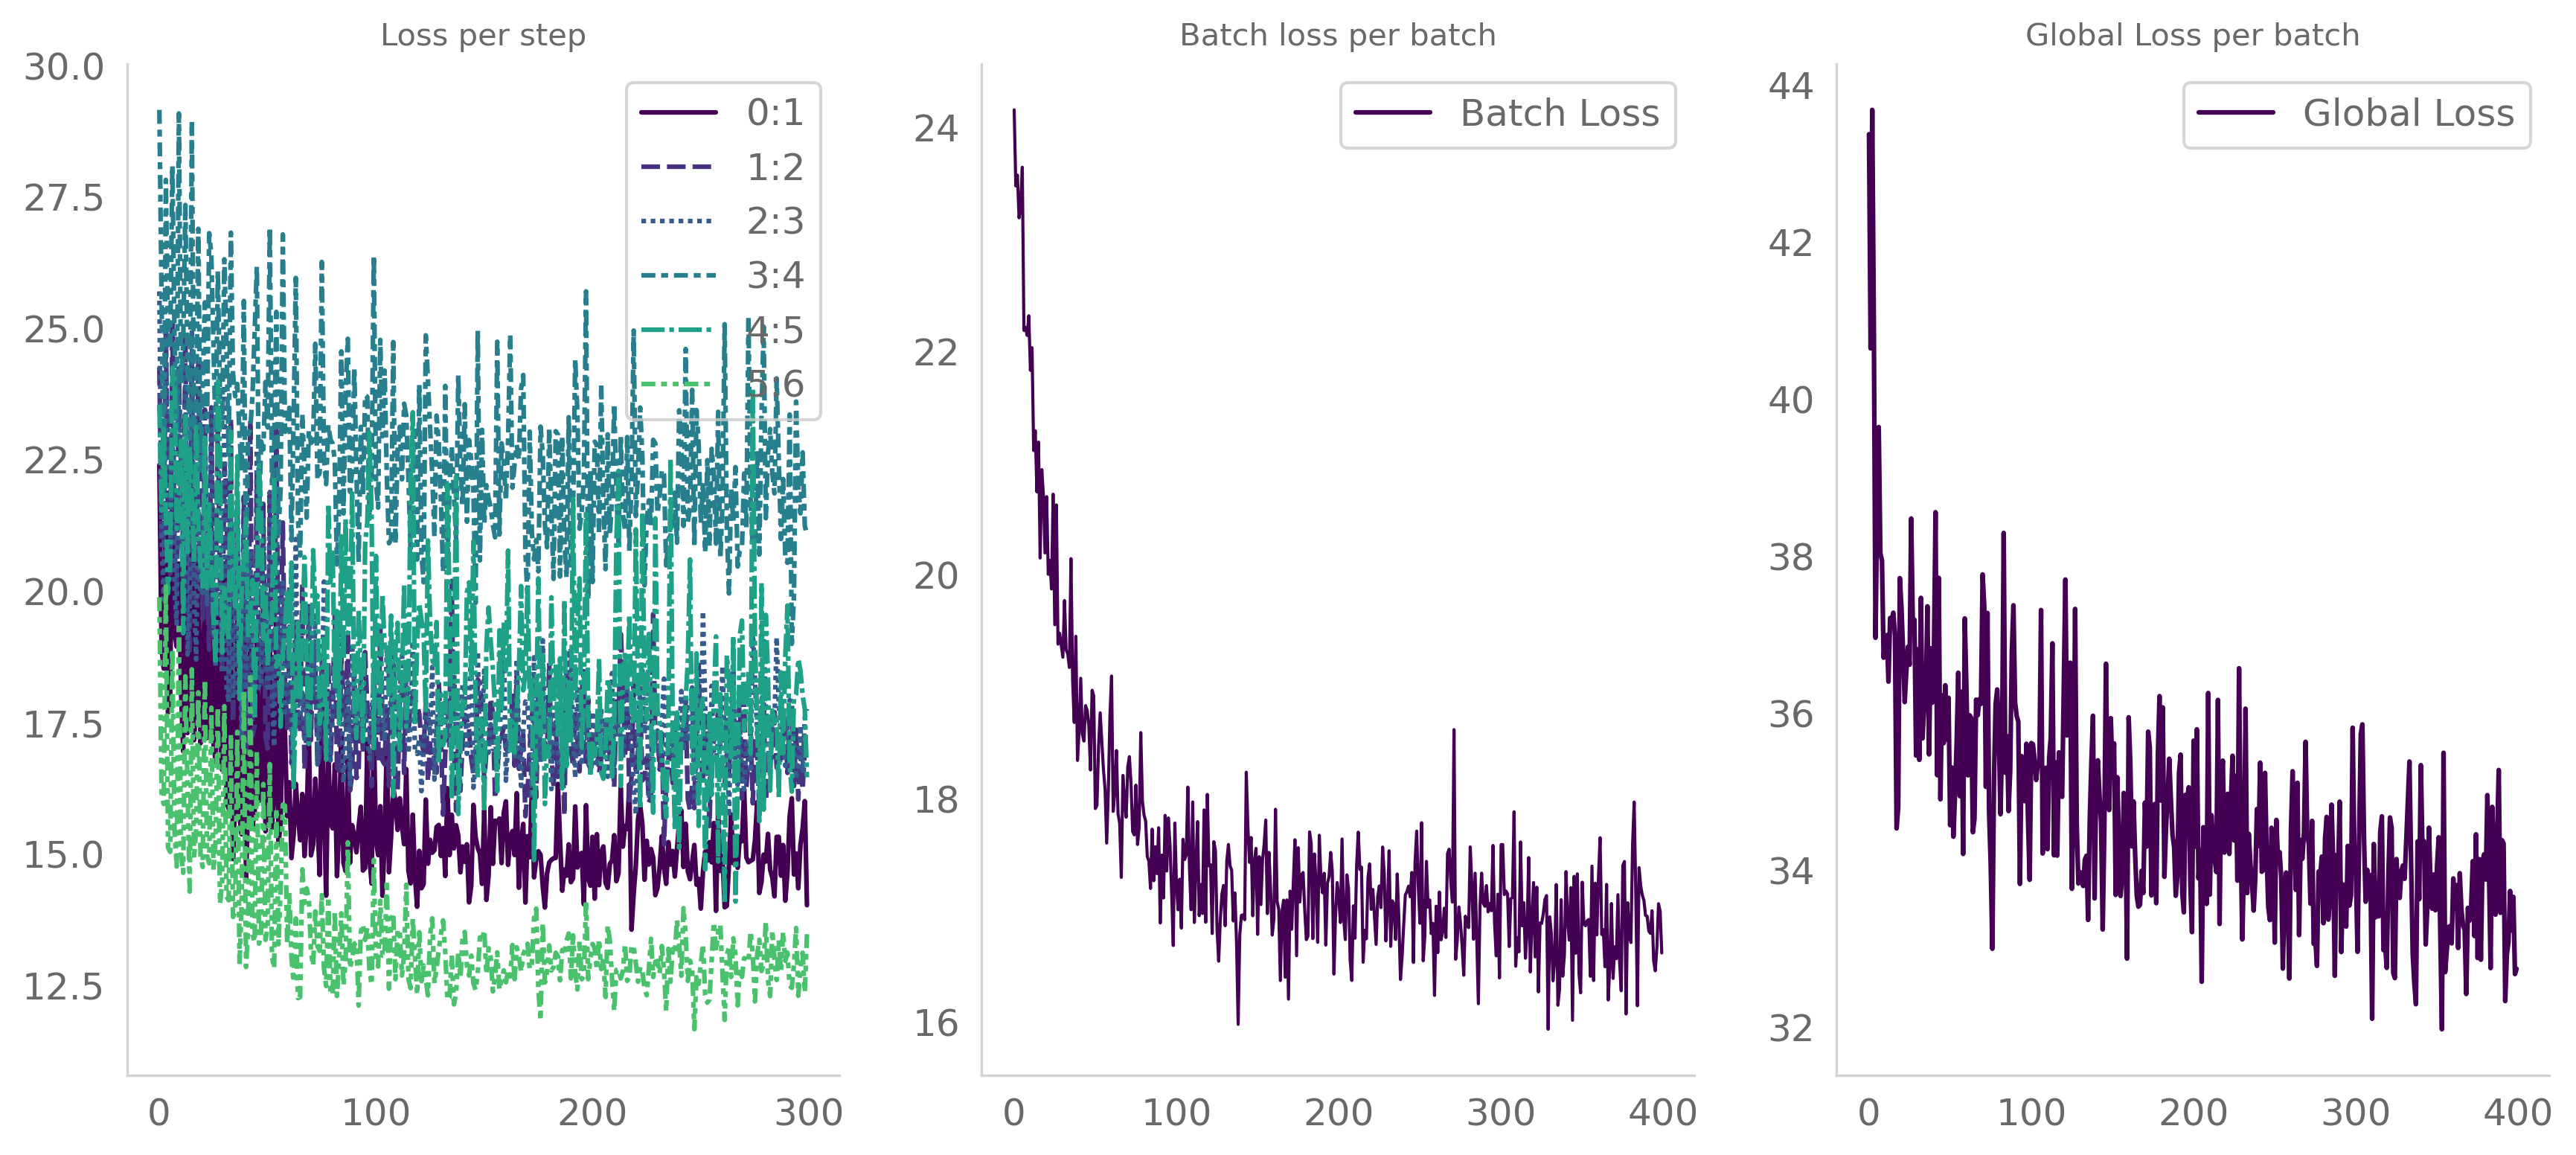

In [31]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [32]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

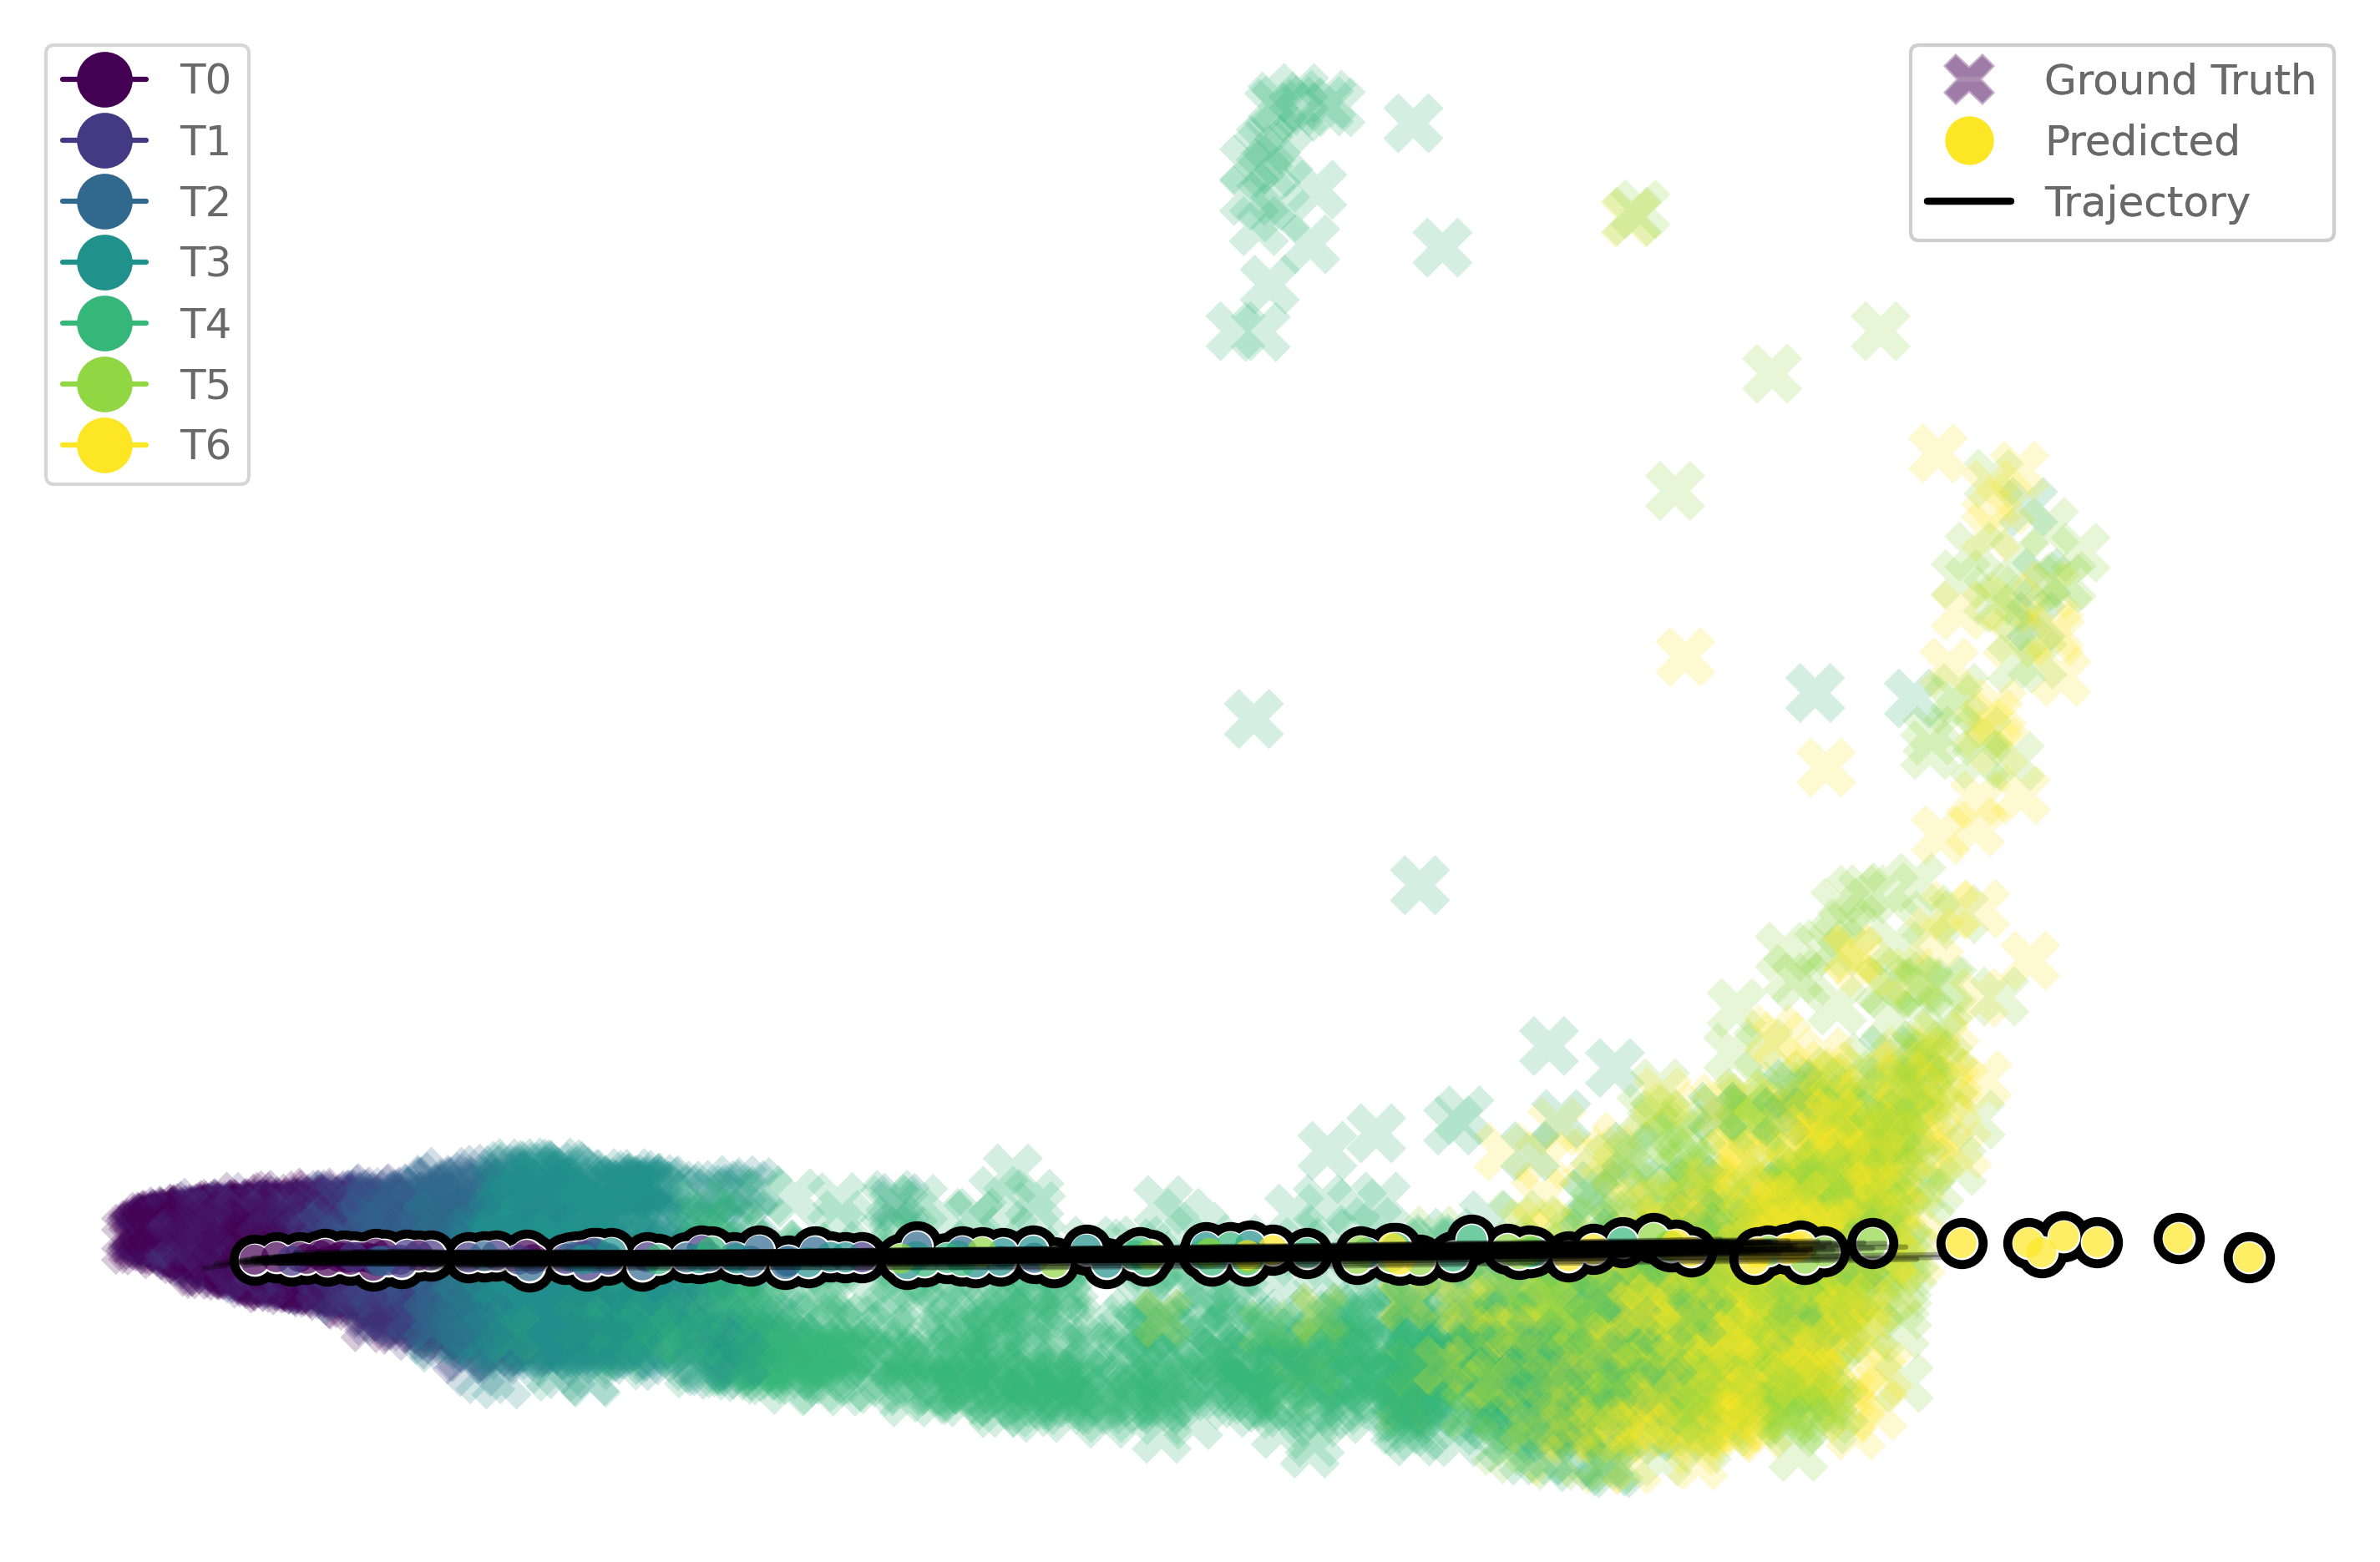

In [33]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

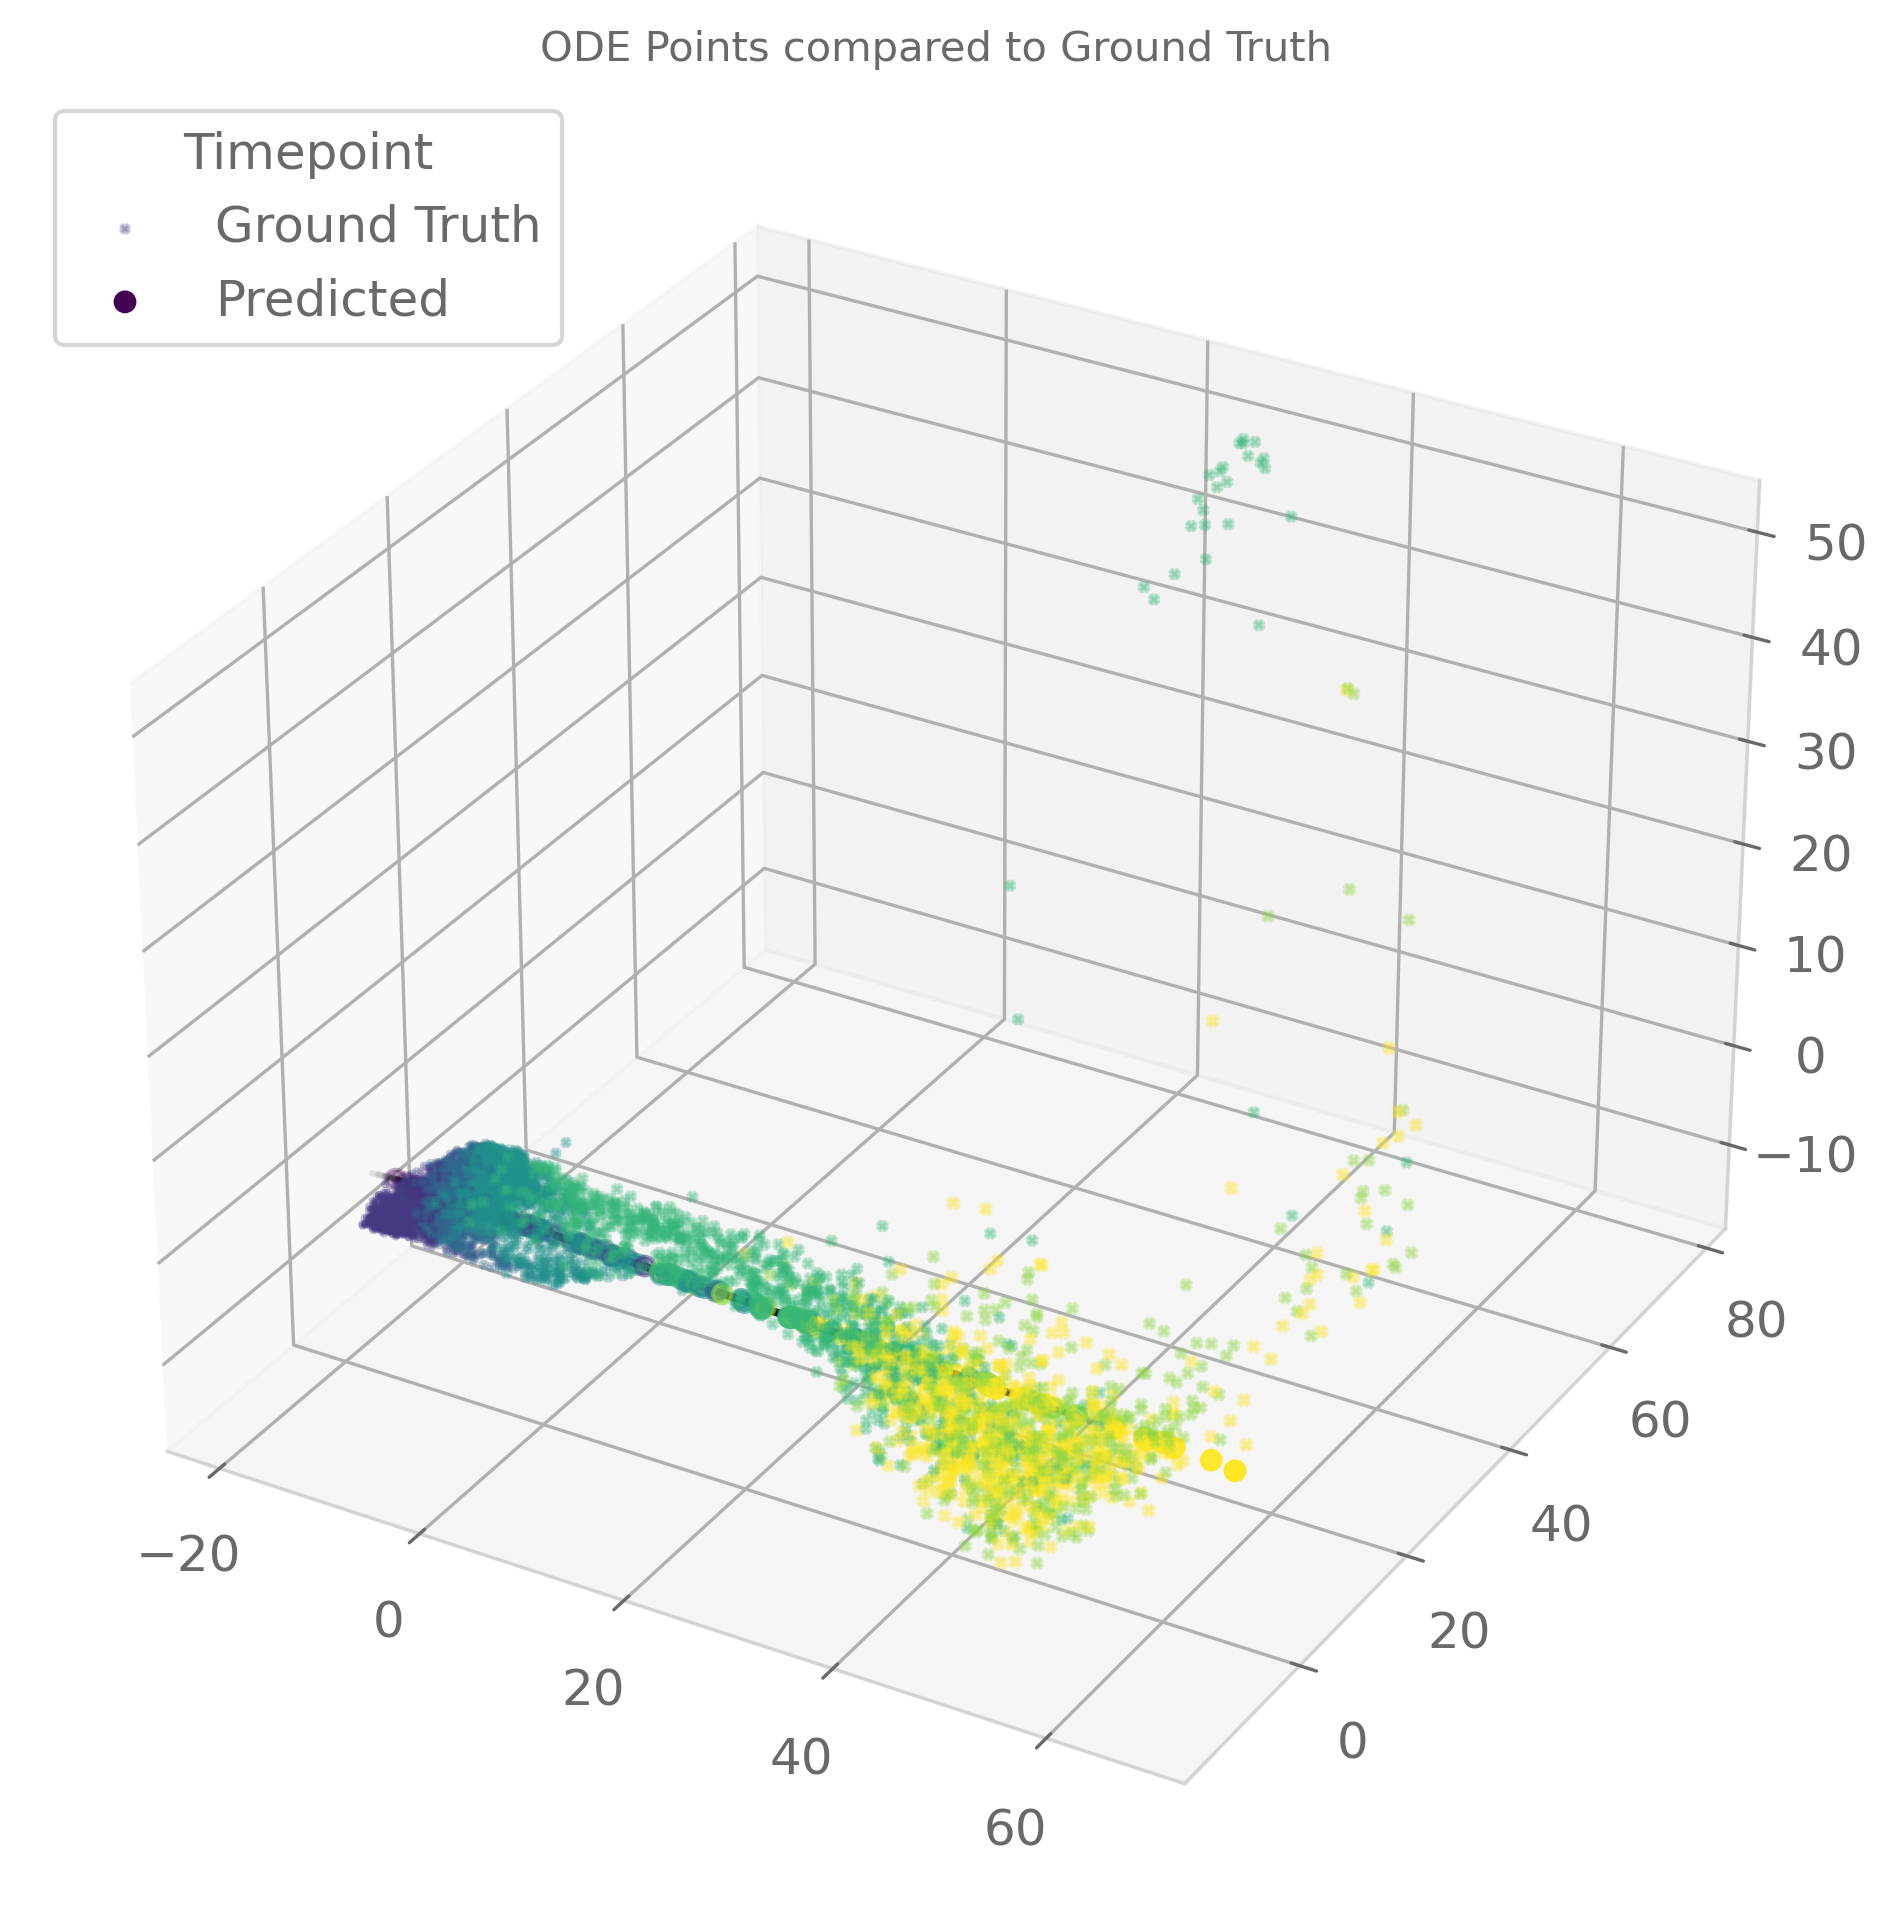

In [34]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=True
)

In [35]:
# saving the trajectories and generated points
#np.save(os.path.join(exp_dir,'trajectories_leave{}.npy'.format(hold_out)),trajectories)
#np.save(os.path.join(exp_dir,'generated_leave{}.npy'.format(hold_out)),generated)
torch.save(model, os.path.join(exp_dir, 'model.model'))
torch.save(autoencoder, os.path.join(exp_dir, 'autoencoder.model'))

# Trajectory Analysis

## Plotting Functions

In [36]:
from ToyTrajectoryNet.utils import to_np, get_groups_from_df, get_cell_types_from_df, get_sample_n_from_df
from ToyTrajectoryNet.eval import generate_tjnet_trajectories, get_cell_indexes
from ToyTrajectoryNet.plots import plot_gene_trends

## Trajectory Visualization

### Plot Some Trajectories

In [37]:
where = 'start'
start = 0

In [38]:
tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start
)

plot_comparision(
    df, generated, 
    tjnet_trajectories[:, np.random.choice(tjnet_trajectories.shape[1], size=(30)), :],
    palette = 'viridis', df_time_key='samples',
    save=False, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

### Plot All Trajectories

In [39]:
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.scatter(
    df['d1'], df['d2'],
    c=df['samples'],
    s=50,
    alpha=0.7,
    marker='o',
    linewidths=0,
    edgecolors=None,
    cmap='viridis'
)
for trajectory in np.transpose(tjnet_trajectories, axes=(1,0,2)):
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.03, color='Black');

## Run Gene Trends Analysis

In [40]:
favorite_genes = '''
Nek5 Dicer1 Fhod1 Kank2 Icam1 Reck Csf1r Sdc4
'''.split()

In [41]:
new_genes = '''
Acvr1 Prkca Mmp14 Sema3c Mylk Itga3 Myh9 Fam171a1
Cnn3 Cnn2 Csrp1 Csrp2 Nebl Fhod1 Arpc5l
'''.split()

In [42]:
genes = favorite_genes
genes = new_genes
where = 'start'
start = 0

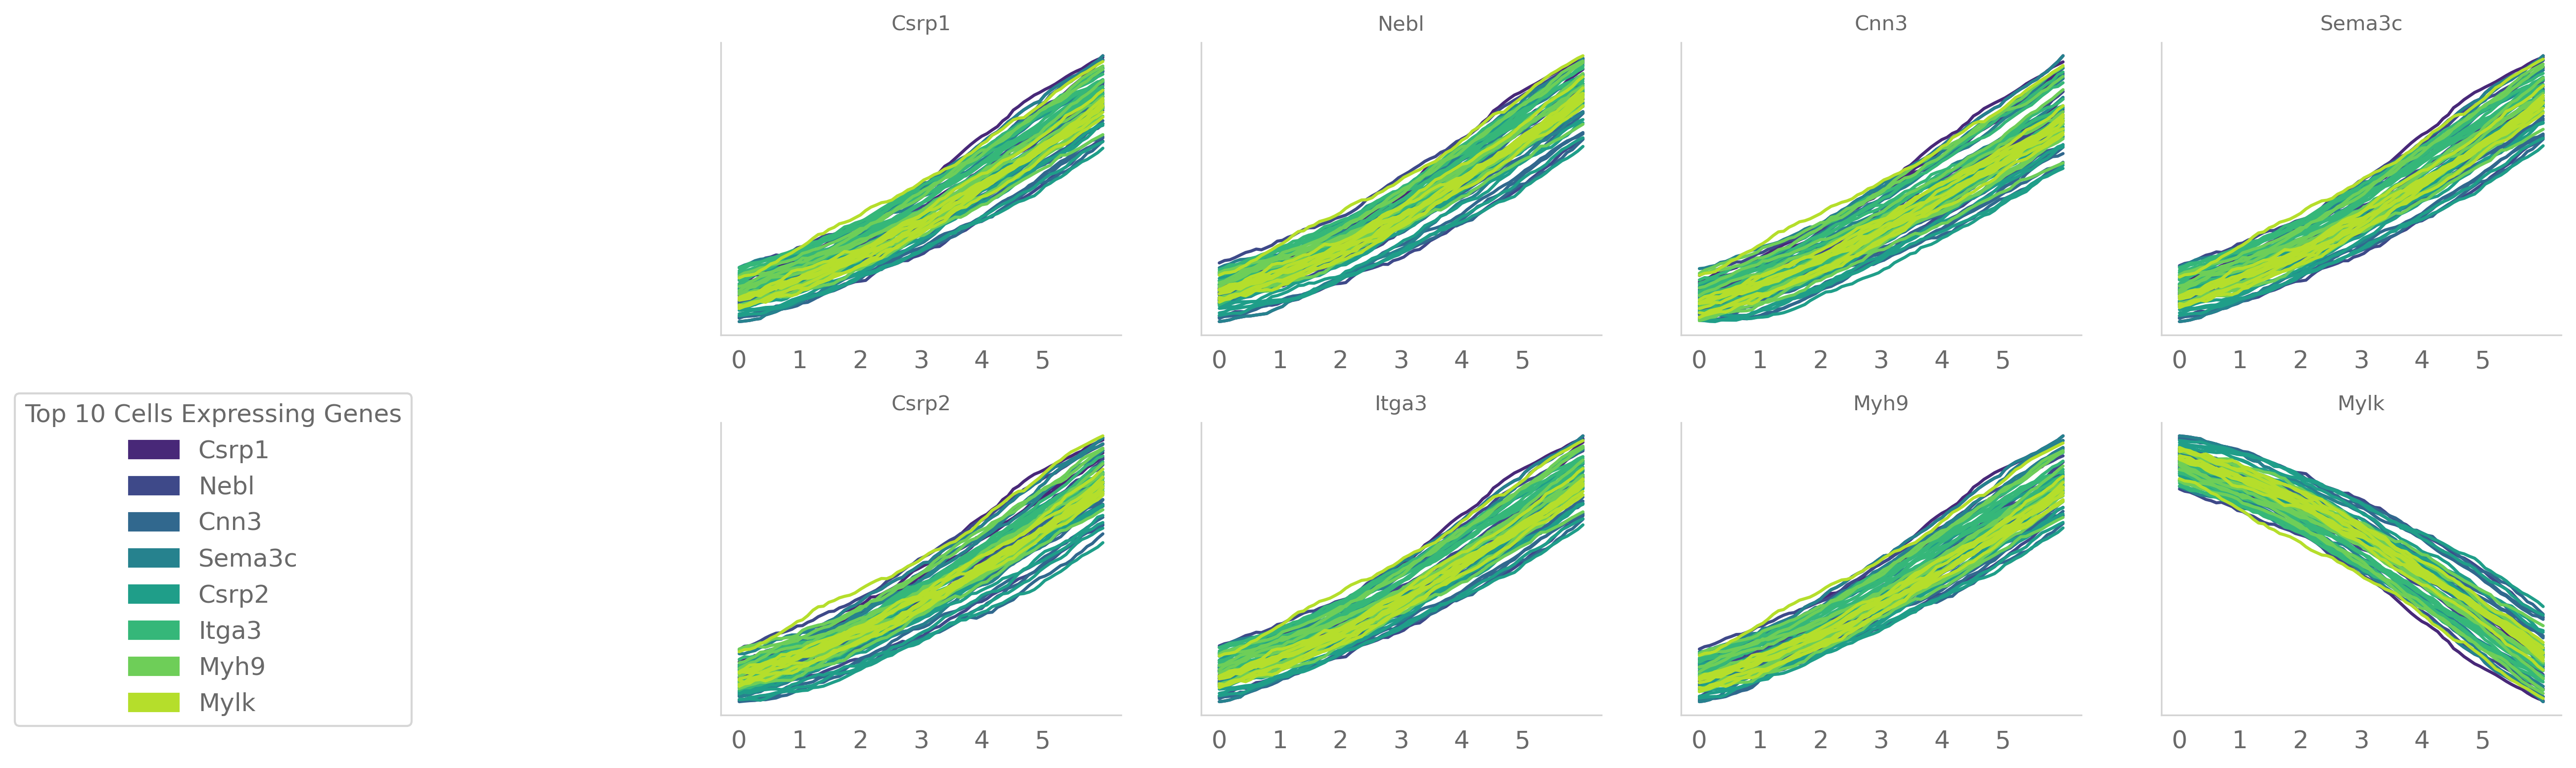

In [43]:
use_cell_types=False
tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start, 
)

# pcs = phate_operator.graph.data_pca.components_
pcs = pca_components
genes, top_idxs, inverse, colors = get_cell_indexes(
    df_m, genes, tjnet_trajectories, pca_components, 
    where=where, start=start, samples=df.samples, use_cell_types=use_cell_types,
#     palette='tab10',
)
fig = plot_gene_trends(
    genes, top_idxs, inverse, colors, n_cols=4, samples=df.samples, where=where, start=start, 
    cell_types='AT1 AT2 Repair'.split(), use_cell_types=use_cell_types
)
fig

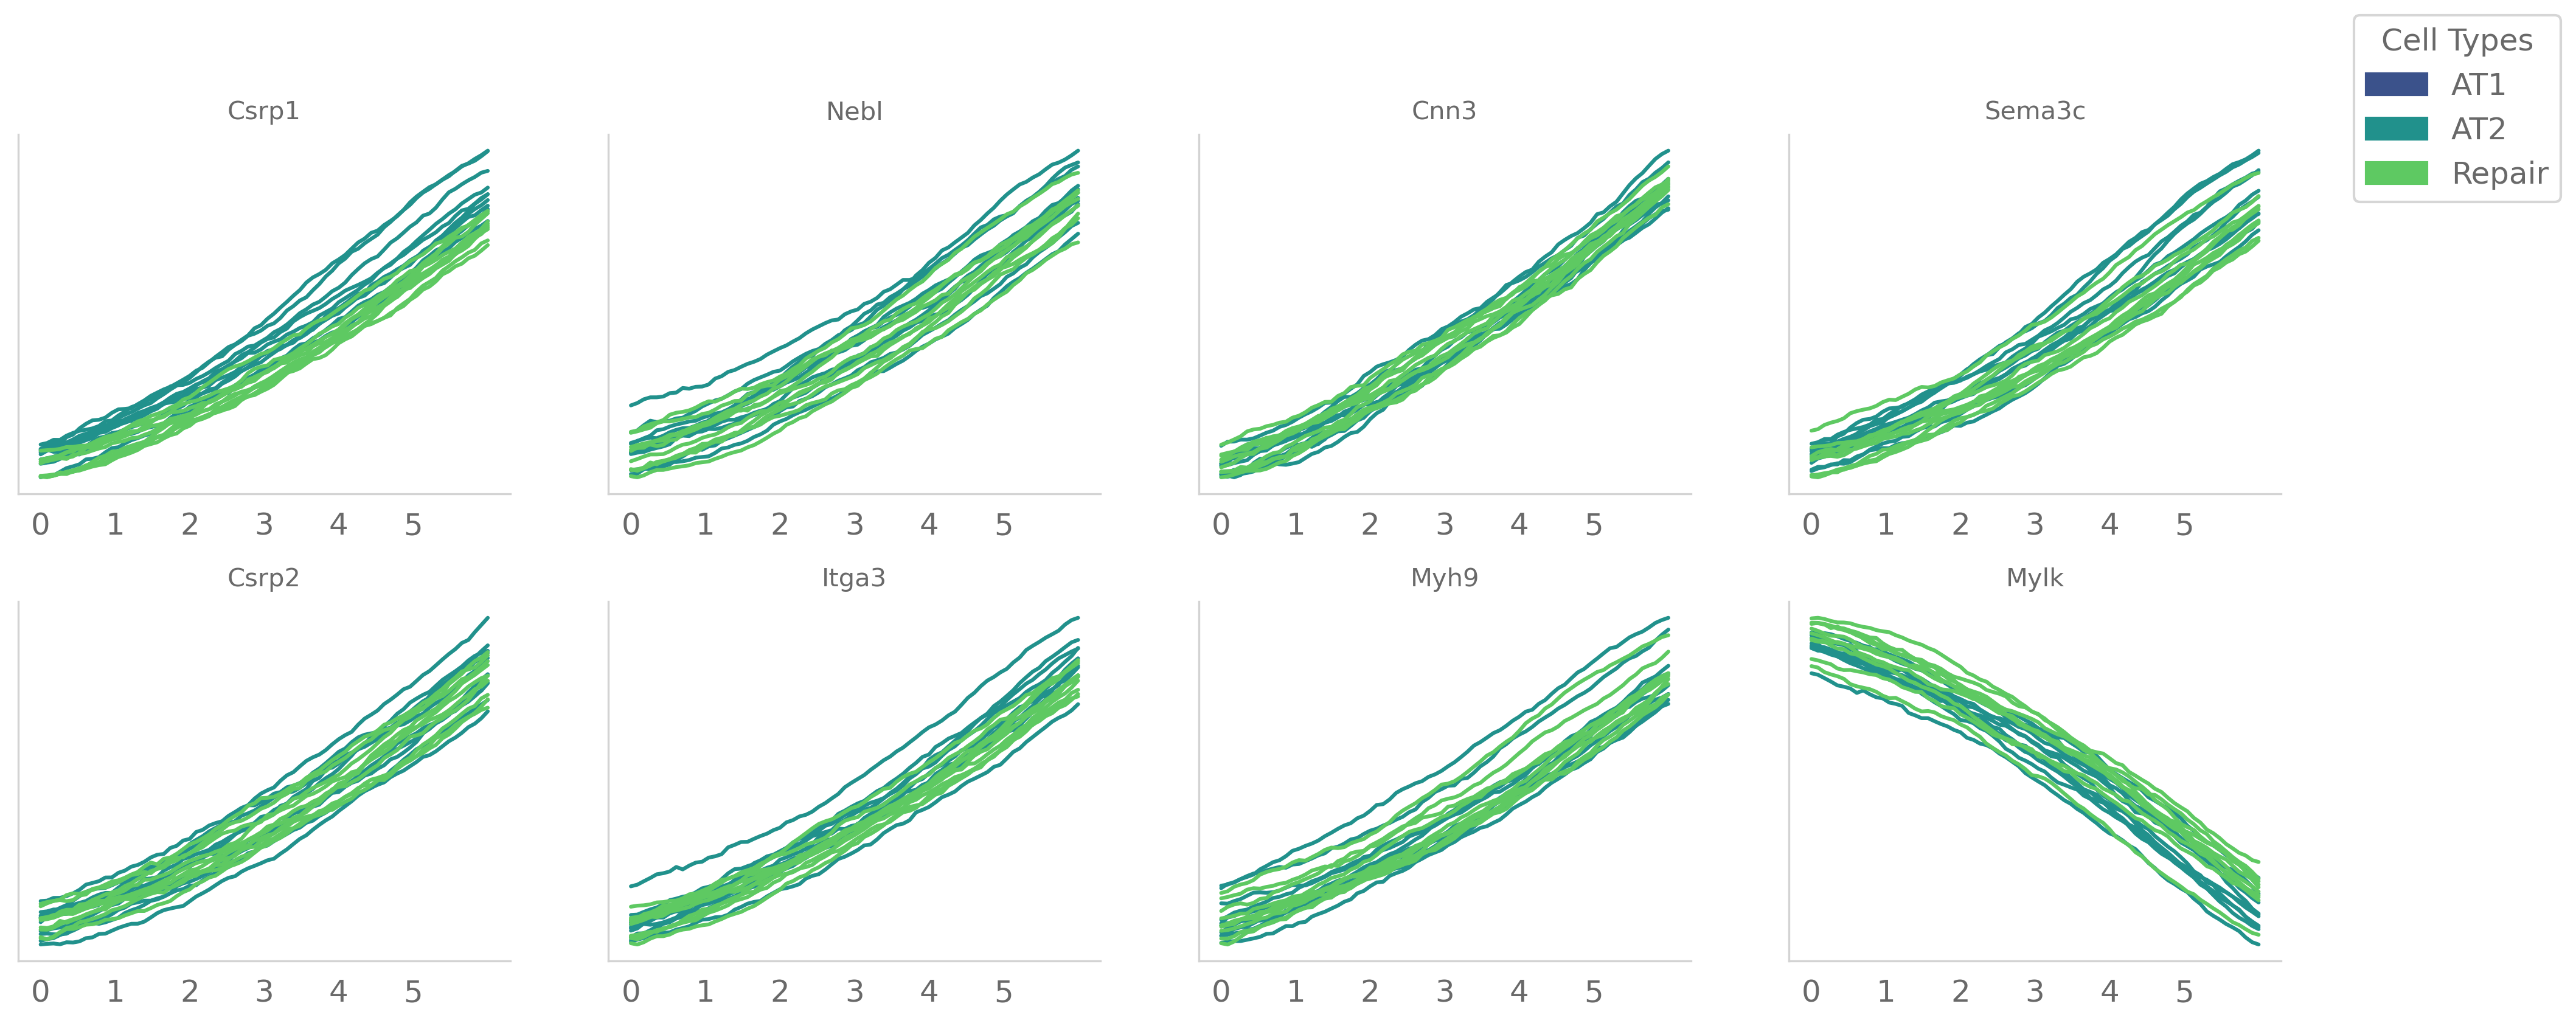

In [44]:
use_cell_types = True

tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start, 
)
genes, top_idxs, inverse, colors = get_cell_indexes(
    df_m, genes, tjnet_trajectories, pca_components, 
    where=where, start=start, samples=df.samples, use_cell_types=use_cell_types,
#     palette='tab10'
)
fig = plot_gene_trends(
    genes, top_idxs, inverse, colors, n_cols=4, samples=df.samples, where=where, start=start, 
    cell_types='AT1 AT2 Repair'.split(), use_cell_types=use_cell_types
)
fig